***Using GNNs to Create Node Embeddings***

This notebook uses a Pytorch Geometric (PyG) GNN architecture to generate node embeddings. No model training is involved: by simply passing the graph into the architecture, we can output embeddings.

This notebook will start an adjacency list file and:
1. Use Pytorch Geometric (PyG) to pre-process the graph into a PyG dataset.
2. Pass the graph through a GNN architecture to produce embeddings.
3. Use T-SNE to reduce the dimensionality of these embeddings.
4. Visualize the embeddings in 2-dimensions.


In [1]:
! python -c "import torch; print(torch.__version__)"

2.0.1+cu118


In [2]:
! python -c "import torch; print(torch.version.cuda)"

11.8


In [3]:
# Install Pytorch Geometric
# Use the information above to fill in the first and second pip lines

# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
# load adjacency list
!gdown --id 1gL63dwzlfjSfBHl8b-JRjBnjyRBhbHAZ # download node attributes csv file
!gdown --id 1IVMAltcyqtxBOY4PwHktNZuj3KYytAkP # download adjacency list file

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gL63dwzlfjSfBHl8b-JRjBnjyRBhbHAZ
To: /content/node_attributes_hashed.csv
100% 155k/155k [00:00<00:00, 107MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IVMAltcyqtxBOY4PwHktNZuj3KYytAkP
To: /content/adjacency_list_test.txt
100% 1.08M/1.08M [00:00<00:00, 168MB/s]


In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import networkx as nx
import pandas as pd

from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric import utils
from torch_geometric.nn import GCNConv, GATConv, GraphConv
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from itertools import count
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

I. Read the adjacency list into NetworkX, then attach attributes to the networkX graph.


In [6]:
social_graph = nx.read_adjlist('adjacency_list_test.txt')

node_attr = pd.read_csv('/content/node_attributes_hashed.csv', encoding = "ISO-8859-1")
node_attr = node_attr[['hashedid','company_type','position_type']]
node_attr = node_attr.set_index('hashedid')
attribute_dict = node_attr.to_dict(orient='index')

nx.set_node_attributes(social_graph, attribute_dict)

Since the graph is disconnected, we select the largest connected component.

For visualization purposes, we create a color mapping from the job_type attribute.

In [7]:
social_graph = social_graph.subgraph(sorted(nx.connected_components(social_graph), key=len, reverse=True)[0])

groups = set(nx.get_node_attributes(social_graph,'company_type').values())

nx.get_node_attributes(social_graph,'company_type')
mapping = dict(zip(sorted(groups),count()))
attr_values = [mapping[attribute_dict[node]['company_type']] for node in social_graph.nodes()]

To make things easier, we incorporate the above steps into a PyG dataset instance.

Specifically, the *process* method of this class is used to load in data from a file and place it into a dataset instance.

In [8]:
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):  #A
        super(MyOwnDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self): #B
        return []

    @property
    def processed_file_names(self): #C
        return ['../test.dataset']

    def download(self): #D
        # Download to `self.raw_dir`.
        pass

    def process(self): #E
        # Read data into `Data` list.
        data_list = []

        eg = nx.read_adjlist('adjacency_list_test.txt')
        node_attr = pd.read_csv('/content/node_attributes_hashed.csv', encoding = "ISO-8859-1")
        node_attr = node_attr[['hashedid','company_type','position_type']]

        node_attr = node_attr.set_index('hashedid')
        node_attr.tail()
        attribute_dict = node_attr.to_dict(orient='index')

        nx.set_node_attributes(eg, attribute_dict)

        eg = eg.subgraph(sorted(nx.connected_components(eg), key=len, reverse=True)[0])  #A

        groups = set(nx.get_node_attributes(eg,'company_type').values())

        nx.get_node_attributes(eg,'company_type')
        mapping = dict(zip(sorted(groups),count()))

        attr_values = [mapping[attribute_dict[node]['company_type']] for node in eg.nodes()]

        list_of_nodes = list(set(list(eg)))
        indices_of_nodes = [list_of_nodes.index(x) for x in list_of_nodes]

        node_to_index = dict(zip(list_of_nodes, indices_of_nodes))
        index_to_node = dict(zip(indices_of_nodes, list_of_nodes))

        list_edges = nx.convert.to_edgelist(eg)
        list_edges = list(list_edges)
        named_edge_list_0 = [x[0] for x in list_edges]
        named_edge_list_1 = [x[1] for x in list_edges]

        _indexed_edge_list_0 = [node_to_index[x] for x in named_edge_list_0]
        _indexed_edge_list_1 = [node_to_index[x] for x in named_edge_list_1]

        indexed_edge_list_0 = _indexed_edge_list_0 + _indexed_edge_list_1
        indexed_edge_list_1 = _indexed_edge_list_1 + _indexed_edge_list_0

        x = torch.FloatTensor([[1] for x in range(len(list_of_nodes))])
        y = torch.FloatTensor(attr_values)
        y = y.long()

        edge_index = torch.tensor([indexed_edge_list_0, indexed_edge_list_1])

        data_example = Data(x=x, y=y, edge_index=edge_index)

        data_list.append(data_example)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [9]:
dataset = MyOwnDataset('')
data = dataset[0]

print()
print(data)
print('===========================================================================================================')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Processing...
Done!



Data(x=[1698, 1], edge_index=[2, 24444], y=[1698])
Number of nodes: 1698
Number of edges: 24444
Average node degree: 14.40
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


A helper function for the T-SNE visualization.

In [10]:
def visualize(h, color, oute):
    '''Helper function for visualization.
       credit: matthias.fey@tu-dortmund.de'''

    z = TSNE(n_components=2).fit_transform(oute.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()



Below, we have a visualization of the code in the GNN class.

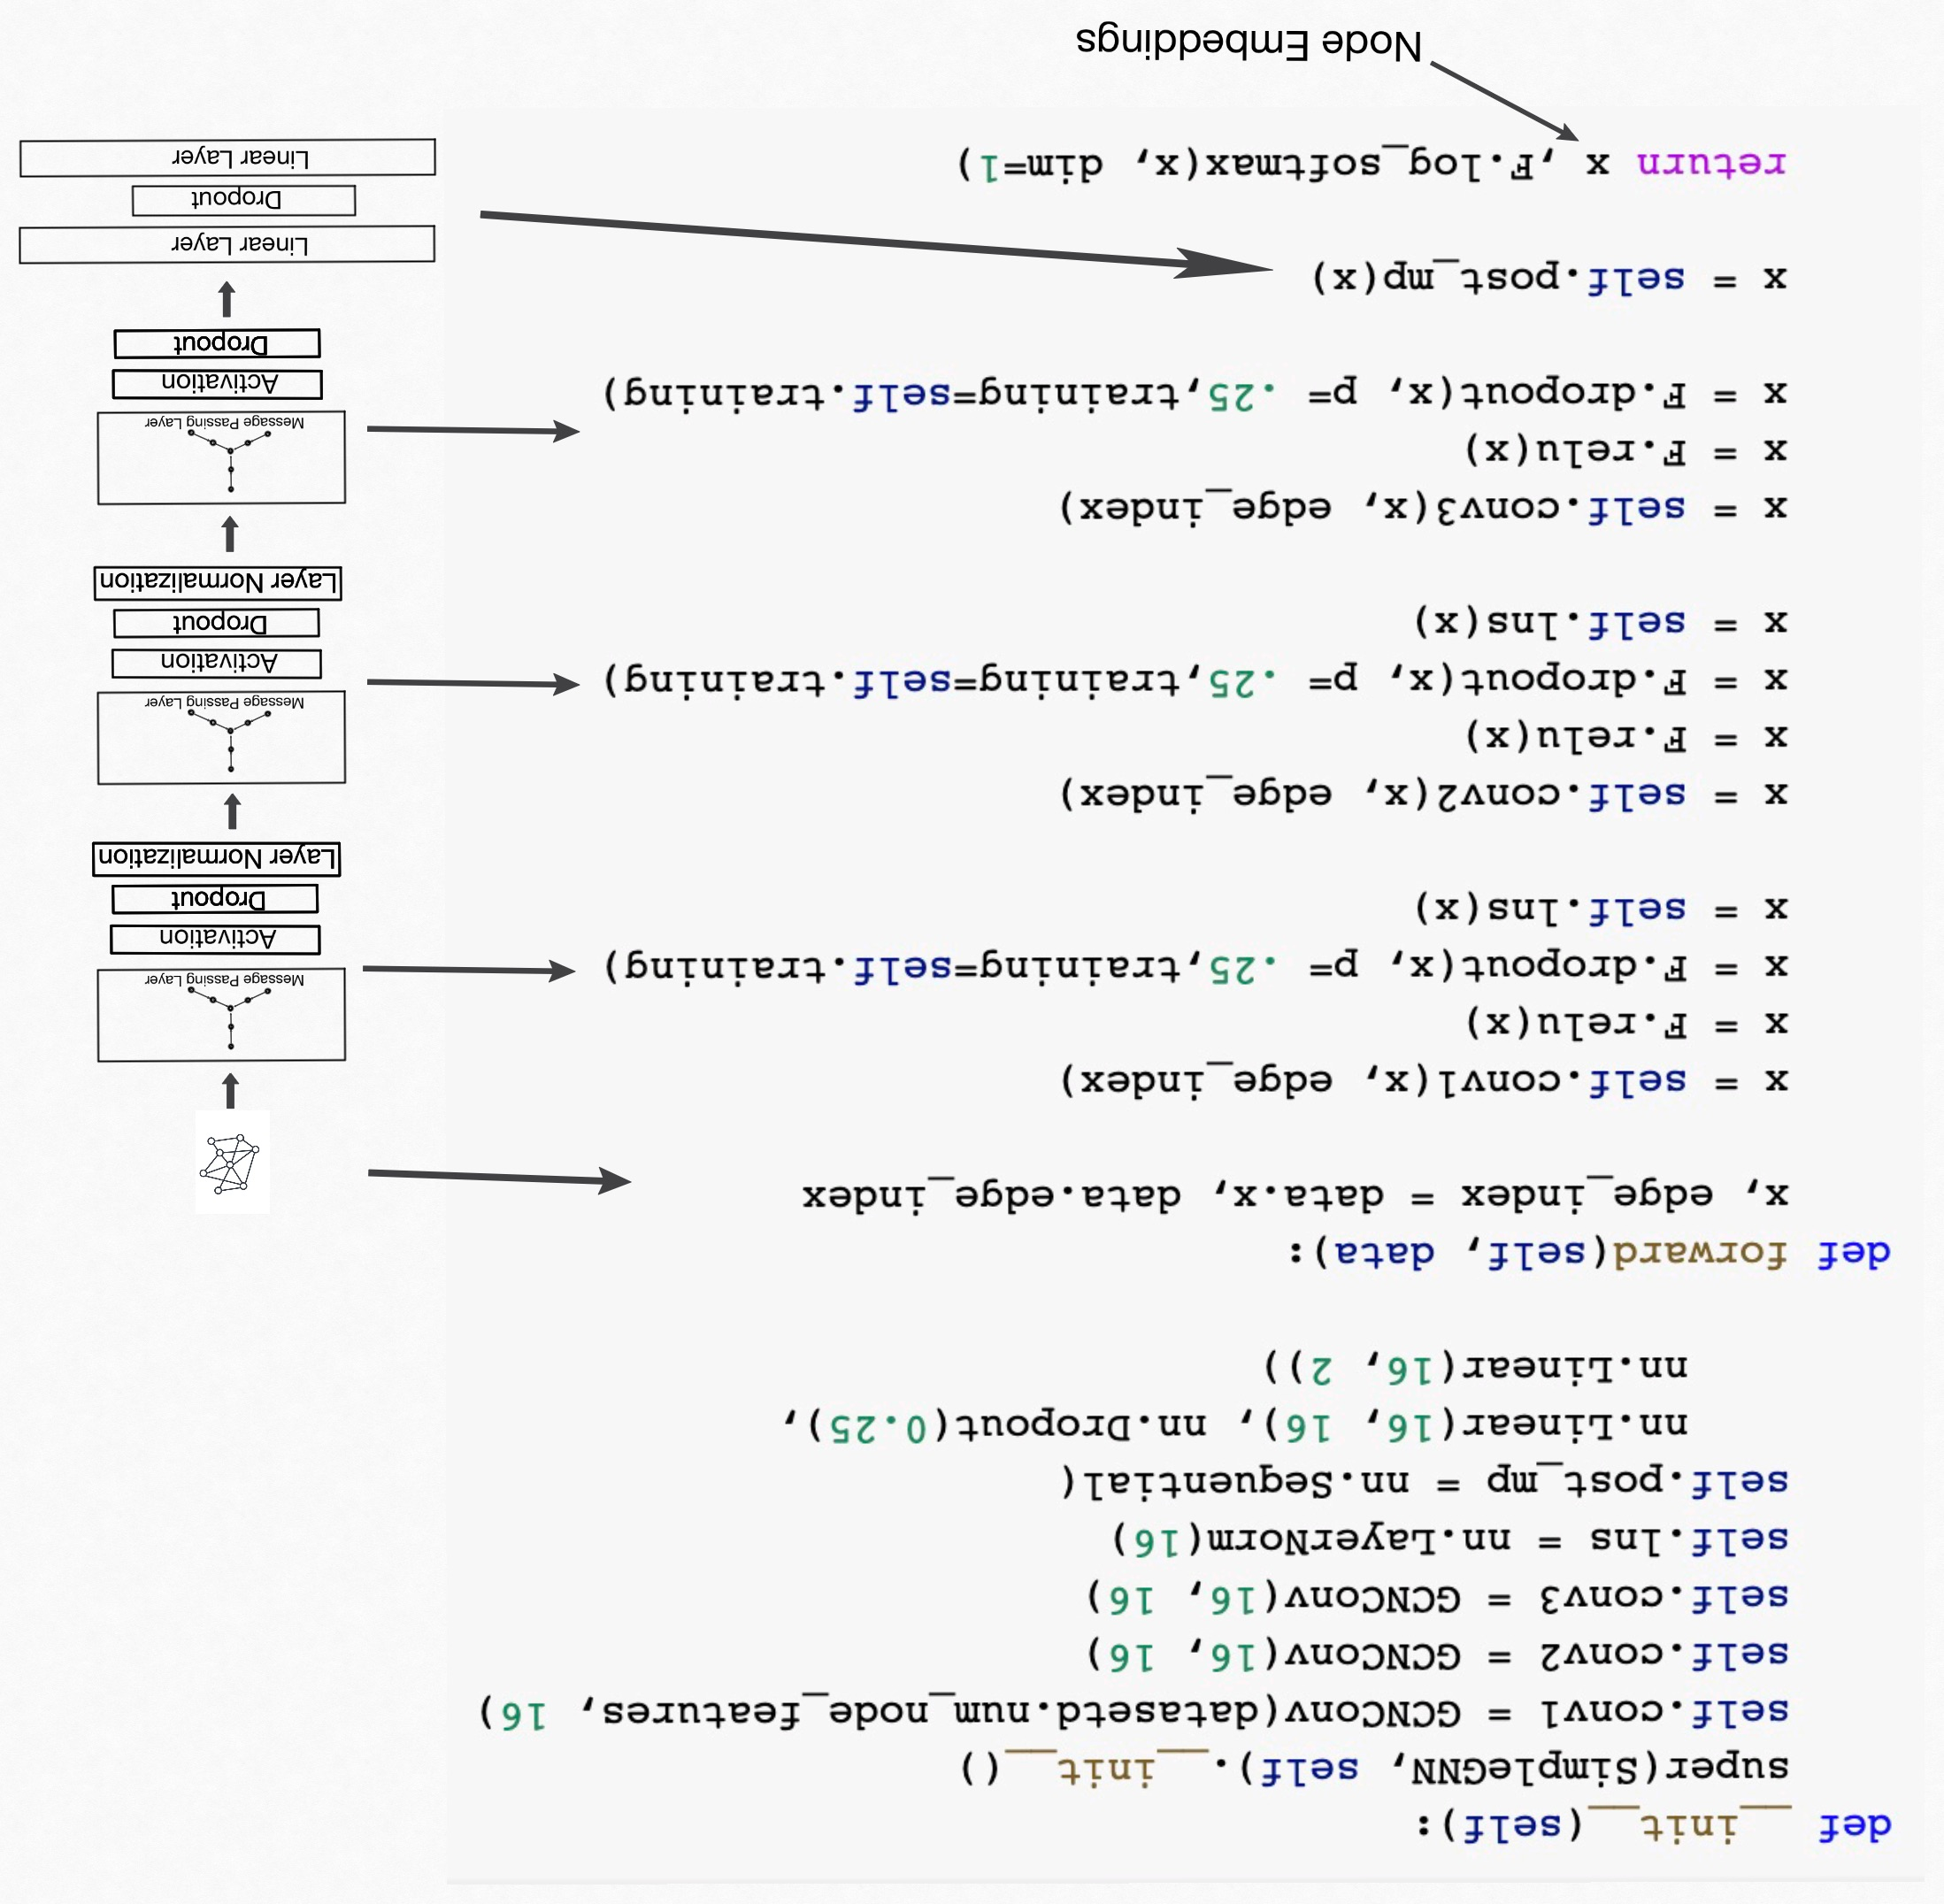

In [11]:

class SimpleGNN(torch.nn.Module):
    '''
        A GNN architecture modified to output embeddings.

        The GNN layers used are built into PyG and can be swappable with
        at least GATConv, GraphConv, and GCNConv.

        The architecture consists of:
        -- 3 GCNConv layers
          - with an activation layer, a dropout layer, and a normalization layer
        -- Multilayer Perceptron layers
          - One linear layer, one dropout layer, and one linear layer

        For this application, we don't use the MLP layers or activation function.
        The output from the message passing layers is directly applied as embeddings.

    '''

    def __init__(self):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16) # Parameter here can be adjusted; Model can be switched between GCNConv, GATConv, or GraphConv
        self.conv2 = GCNConv(16, 16) # Parameter here can be adjusted; Model can be switched between GCNConv, GATConv, or GraphConv
        self.conv3 = GCNConv(16, 16) # Parameter here can be adjusted; Model can be switched between GCNConv, GATConv, or GraphConv
        self.lns = nn.LayerNorm(16) # Parameter here can be adjusted;
        self.post_mp = nn.Sequential(
            nn.Linear(16, 16), nn.Dropout(0.25), # Parameters here can be adjusted;
            nn.Linear(16, 64)) # Parameters here can be adjusted; The right hand parameter, here, will be the dimension of the output embeddings.

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p= .25,training=self.training)
        x = self.lns(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p= .25,training=self.training)
        x = self.lns(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p= .25,training=self.training)

        x = self.post_mp(x)

        return x ,F.log_softmax(x, dim=1)



In the following lines, we do a single pass of the graph data through the GNN architecture.

Then, to add color to our visualization, we use the assign colors to each node, depending on its *company_type*.

Lastly, we use T-SNE to create a 2-dimensional respresentation of the node embeddings, then visualize these.

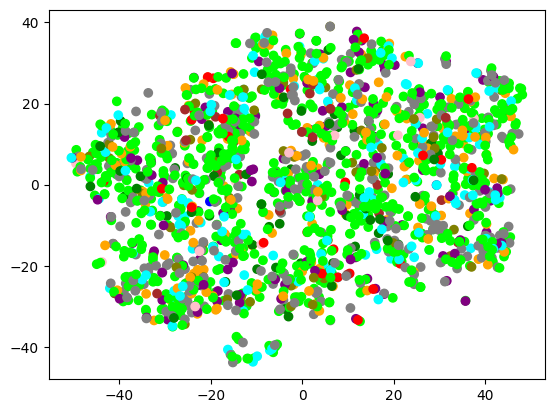

In [12]:
model = SimpleGNN()
embedding, out = model(data)

color_list = ["red", "orange", "green", "blue", "purple", "brown", "pink", "gray", "olive", "cyan", "lime"]
colors = []
colors += [color_list[y] for y in data.y.detach().numpy()]

xs, ys = zip(*TSNE().fit_transform(embedding.detach().numpy()))

plt.scatter(xs, ys, c=colors)

In [13]:
embedding

tensor([[-0.1312,  0.3851,  0.1630,  ...,  0.1859, -0.2815, -0.1954],
        [-0.1455,  0.2720,  0.1665,  ...,  0.0824, -0.0213, -0.2863],
        [-0.4363,  0.4496, -0.0748,  ...,  0.4774, -0.2799, -0.2606],
        ...,
        [-0.0928,  0.3210,  0.2320,  ..., -0.0366, -0.1356, -0.0797],
        [-0.1529,  0.8905,  0.1511,  ...,  0.3198, -0.5215, -0.1790],
        [-0.2014,  0.3534,  0.1284,  ...,  0.1690, -0.2749, -0.3198]],
       grad_fn=<AddmmBackward0>)